# Imports

In [58]:
%load_ext autoreload
%autoreload 2

import cellforest as cf
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Branch

There are many ways to process a single dataset -- changing parameters, adding or removing processing steps, filtering or partitioning data. A `CellBranch` represents a single path through a chain of processes, multiple of which can be easily created to comparatively peer into "parallel universes" of processing.

### Load 10X Sample Data

TODO: this is just loading the 150 x 300

In [59]:
cellranger_dir = Path("tests/data/filtered_gene_bc_matrices/hg19/")

In [60]:
from tests.utils.get_test_data import get_test_data
if not cellranger_dir.exists():
    get_test_data(keep_raw=True)
    if not cellranger_dir.exists():
        raise ValueError("Notebook must be updated to conform to `get_test_data`")

In [61]:
ls {cellranger_dir}

barcodes.tsv  genes.tsv  matrix.mtx


### Get or Create Metadata

This set of metadata contains only two columns:

`entity_id`: contains the sample or lane identifier, which will be appended to the cell barcodes to prevent barcode collisions in the case of multiple lanes

`path_rna`: the directory path to the cellranger outputs containing the `matrix.mtx(.gz)`, `barcodes.mtx(.gz)`, and `features.mtx(.gz)`. (Many older file formats are supported as well)

Usually, the metadata would contain much more information which may be useful during analysis, e.g. patient information, cell processing information, etc. The only requirement is that column names don't start with `path_`.

In [62]:
cellforest_dir = Path(os.path.abspath(""))
sample_dir = cellforest_dir / "tests/data/filtered_gene_bc_matrices/hg19/"

TODO: more samples

In [63]:
df = pd.DataFrame({"entity_id": ["sample_1"], "path_rna": [str(sample_dir)]})

### Create a Branch

The branch requires a `root`, or a directory where all datasets are combined into a single matrix. From here, plotting, QC, data subsetting, and further processing can be done.

Specify a directory for the root. Use any directory -- it will be created if it doesn't yet exist. Note: **use absolute paths, not relative ones**

In [64]:
example_dir = cellforest_dir / "tests/data/example_usage"

In [65]:
root_path = example_dir / "root"

In [ ]:
# rm -r {root_path}

Use the `from_sample_metadata` function to combine the input datasets specified in `meta` into the `root_dir` and instantiate a branch (`CellBranch`) object from it.

This is only required the first time, however, as the combined data has been saved to `root_path`. Once the root has been created, `cf.load` can be used in subsequent sessions.

In [66]:
br = cf.from_sample_metadata(root_path, df)
# br = cf.load(root_path)

In [67]:
br

Note: If you find yourself grievously impovrished of metadata, you can replace `from_sample_metadata` with `from_input_dirs`, passing a list of paths to 10X outs dirs rather than a dataframe as the second arg.

Additional plotting functions can be found in `advanced_usage.ipynb`

# Processing

### Spec

A set or process steps is defined by a `branch_spec`, which is a list of dictionaries, each dictionary representing the specification for a given process, and the order of the list representing the order of execution. The keys in each dictionary tell the process how to execute.

Rather than attempting to remember the structure of the `branch_spec`, one can start with the provided example and modify it as needed.

In [68]:
spec = cf.defaults.spec_markers
spec

[{'_PROCESS_': 'normalize',
  '_PARAMS_': {'min_genes': 0,
   'max_genes': 37000,
   'min_cells': 3,
   'nfeatures': 3000,
   'perc_mito_cutoff': 100,
   'method': 'seurat_default'}},
 {'_PROCESS_': 'reduce',
  '_PARAMS_': {'pca_npcs': 30,
   'umap_n_neighbors': 30,
   'umap_min_dist': 0.3,
   'umap_n_components': 2,
   'umap_metric': 'correlation'}},
 {'_PROCESS_': 'cluster', '_PARAMS_': {'num_pcs': 3, 'res': 0.5, 'eps': 0.1}},
 {'_PROCESS_': 'markers',
  '_PARAMS_': {'logfc_thresh': 0.25, 'test': 'wilcox'}}]

The keys in this default spec are:
- `_PROCESS_`: the name of the process to be executed
- `_PARAMS_`: a dict of params to be fed to that process
Additionally, keys can be specified to subset, filter, or partition the cells based on columns in the metadata before it's passed to the process.
- `_SUBSET_`: a dict of column names and accepted column values. For example: `{"entity_id": "sample_1"}`. To accept multiple values for a given column, provide a list of accepted values, and to subset by multiple columns, use multiple keys
- `_FILTER_`: same as `_SUBSET_`, but rather than specified values being kept, they are removed. Be default, if multiple keys are provided, each filter is applied separately. The `_MULTI_` key can be used to apply multiple filters jointly, which is covered in `advanced_usage.ipynb`.

Note that subsets and filters will persist into any downstream processes of that in which they're specified.

For `normalize`, the `_PARAMS_` show that it doesn't do filtering by minimum expressed genes or percent mitochondrial UMIs, which is a good choice for a first pass analysis to do QC and get a lay of the land. Let's pretend that we've already done this, and want to set a mitochondrial filtering threshold of 25% for our branch. 

In [69]:
spec[1]["_PARAMS_"]["perc_mito_cutoff"] = 25

Our current branch has no `branch_spec`, only the root, so it isn't actually ready for processing. To make a processing-ready branch, we must supply this information

In [70]:
br = cf.load(root_path, branch_spec=spec)

In [71]:
br.spec

[{'_PROCESS_': 'normalize',
  '_PARAMS_': {'min_genes': 0,
   'max_genes': 37000,
   'min_cells': 3,
   'nfeatures': 3000,
   'perc_mito_cutoff': 100,
   'method': 'seurat_default'}},
 {'_PROCESS_': 'reduce',
  '_PARAMS_': {'pca_npcs': 30,
   'umap_n_neighbors': 30,
   'umap_min_dist': 0.3,
   'umap_n_components': 2,
   'umap_metric': 'correlation',
   'perc_mito_cutoff': 25}},
 {'_PROCESS_': 'cluster', '_PARAMS_': {'num_pcs': 3, 'res': 0.5, 'eps': 0.1}},
 {'_PROCESS_': 'markers',
  '_PARAMS_': {'logfc_thresh': 0.25, 'test': 'wilcox'}}]

### Process Execution

Now we can access the processes via the `CellBranch.process` attribute. Try not to stop processes midway through, which could cause errors in the filesystem. If you do stop midway, it is advisable to delete the containing folder

In [72]:
br.process.normalize()

Note: `stop_on_error=True` and `stop_on_hook_error=True` may be helpful arguments for debugging.

normalize also filters, so shape will likely change

In [73]:
br.rna.shape

(2700, 32738)

In [74]:
br.process.reduce()

In [75]:
br.process.cluster()

In [76]:
br.process.markers()

Note that the results of all processing have now been saved to disk for this root and spec, and so you won't have to run the above ever again. Instead, you can simpley use `br = cf.load(...)` with your root and spec, then e.g. `br.goto_process("markers")` to traverse the branch, which will update `br.current_process`

# Plotting

To see the available plotting methods, check the [documentation](https://github.com/TheAustinator/cellforest/tree/feature/plotting-updates/cellforest#iii-all-implemented-plots). When we get behind on documentation, some plots may be missing, so the names of all plotting methods can be viewed via:

In [77]:
br.plot.methods

{'root': {'plot_cell_cycle_scoring_scat',
  'plot_expressing_cells_bar',
  'plot_expressing_cells_bar_facet_gene',
  'plot_frac_cells_recovered_bar',
  'plot_genes_per_cell_hist',
  'plot_highest_exprs_dens',
  'plot_hist_features',
  'plot_marker_genes_per_cluster_bar',
  'plot_meta_vln',
  'plot_pca_elbow_curv',
  'plot_pca_embeddings_scat',
  'plot_pca_loadings_scat',
  'plot_perc_hsp_per_cell_hist',
  'plot_perc_hsp_per_cell_vln_r',
  'plot_perc_mito_per_cell_hist',
  'plot_perc_mito_per_cell_vln_r',
  'plot_perc_ribo_per_cell_hist',
  'plot_perc_ribo_per_cell_vln_r',
  'plot_umap_embeddings_scat',
  'plot_umap_embeddings_scat_r',
  'plot_umap_features',
  'plot_umis_per_barcode_rank_curv',
  'plot_umis_per_cell_hist',
  'plot_umis_vs_genes_scat',
  'plot_umis_vs_perc_hsp_scat',
  'plot_umis_vs_perc_mito_scat',
  'plot_umis_vs_perc_mito_scat_r',
  'plot_umis_vs_perc_ribo_scat',
  'plot_umis_vs_perc_ribo_scat_r'}}

The fact that they all show up under `root` is a bug -- those that require e.g. `cluster` will only become available after when `br.current_process` is at cluster or later

In [78]:
br.goto_process("markers")

<Figure size 432x288 with 0 Axes>

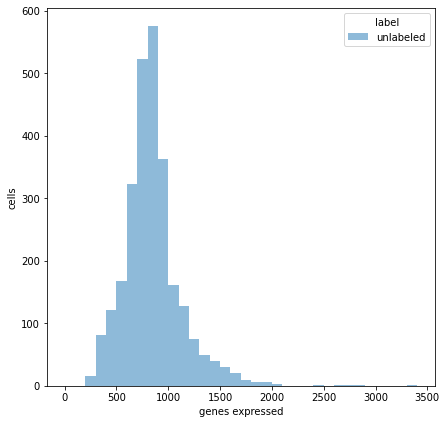

In [79]:
br.plot.plot_genes_per_cell_hist(alpha=0.5, show=False, bins=np.arange(0, 3500, 100));

Note: `show=False` is so that only one plot shows up. In the case that no plots show up, try setting `show=True`

Most of these functions use matplotlib under the hood, so you can pass matplotlib keyword arguments (kwargs) in addition to some of our custom ones. Note that the custom kwargs may not work for every plot type

Custom kwargs:
- **stratify** (str or List[str]): color by column(s) from metadata
- **facet** (str or List[str]): separate subplots by column(s) from metadata
- facet_dim: (Tuple[int]): dimensions of subplots. Can specify one dimension and use `None` to auto-calc the other. E.g. (2, 2) or (2, None)
- xlim, ylim (Tuple[int or float]): lower and upper limits for axis e.g. (0, 1)
- xscale, yscale {"linear", "log", "symlog", "logit", ...}: scale for axis
- figsize (Tuple[int]): figure size in inches e.g. (4, 8)
- ax (maplotlib.axes.Axes): plot on existing `Axes` object
- fig (matplotlib.figure.Figure): plot on existing `Figure` object

Stratifying by two columns isn't useful in the example below since there's only one `entity_id` in the data, but would be useful if there were more

In [80]:
cat /home/ubuntu/code/cellforest/tests/data/example_usage/root/normalize/kfl1H260/reduce/KYgXrxtY/cluster/aDrIv5Pd/markers/4W3QIwLz/_logs/plot_highest_exprs_dens.err

cat: /home/ubuntu/code/cellforest/tests/data/example_usage/root/normalize/kfl1H260/reduce/KYgXrxtY/cluster/aDrIv5Pd/markers/4W3QIwLz/_logs/plot_highest_exprs_dens.err: No such file or directory


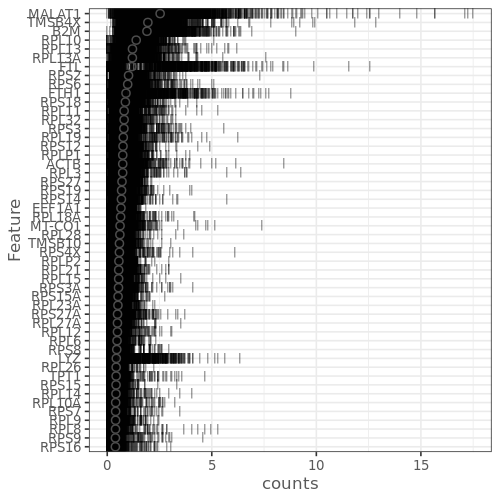

[<IPython.core.display.Image object>]

In [81]:
br.plot.plot_highest_exprs_dens(stop_on_error=True)

/home/ubuntu/code/cellforest/cellforest/plot/reduce.py:43: MatplotlibDeprecationWarning: The 'alpha' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(scat, ax=ax, alpha=1, pad=0)


(<Figure size 500x500 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

<Figure size 432x288 with 0 Axes>

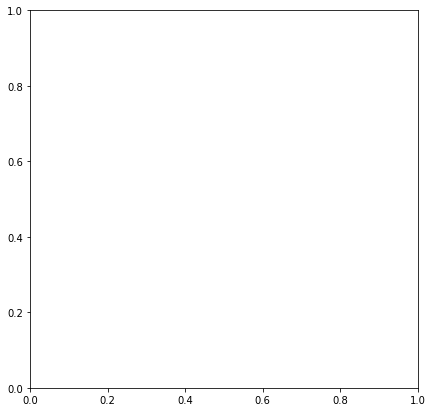

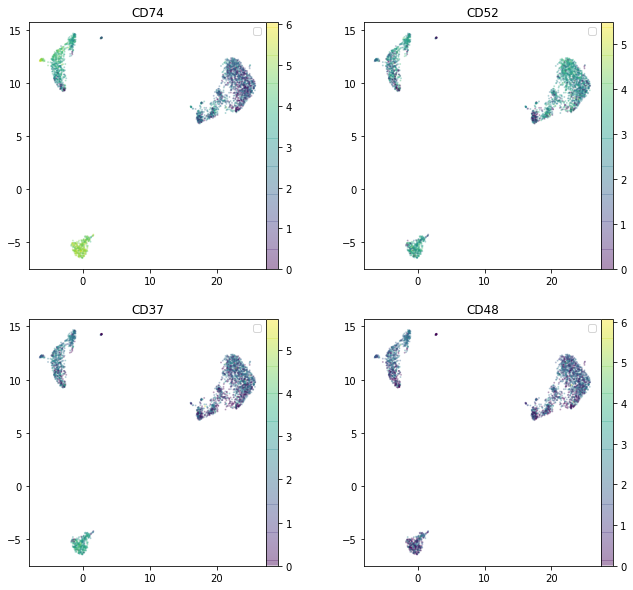

In [82]:
br.plot.plot_umap_features(features=["CD74", "CD52", "CD37", "CD48"], alpha=0.25, s=1, ncol=2, stop_on_error=True, show=False)

<Figure size 432x288 with 0 Axes>

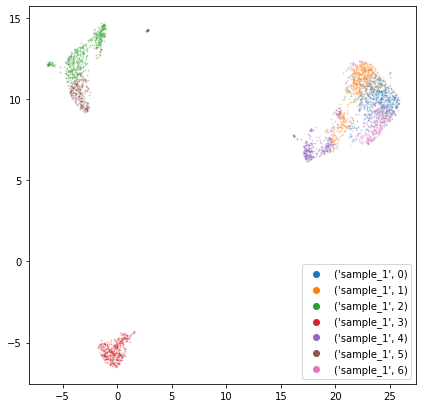

In [83]:
br.plot.plot_umap_embeddings_scat(alpha=0.25, s=1, stratify=["entity_id", "cluster_id"], show=False);

# Tree

A branch is a single lineage of processing steps with specific parameters, subsets, etc. A tree is a collection of branches created by trying multiple different parameters, subsets, etc.

In [84]:
tree_spec = cf.defaults.spec_markers
tree_spec

[{'_PROCESS_': 'normalize',
  '_PARAMS_': {'min_genes': 0,
   'max_genes': 37000,
   'min_cells': 3,
   'nfeatures': 3000,
   'perc_mito_cutoff': 100,
   'method': 'seurat_default'}},
 {'_PROCESS_': 'reduce',
  '_PARAMS_': {'pca_npcs': 30,
   'umap_n_neighbors': 30,
   'umap_min_dist': 0.3,
   'umap_n_components': 2,
   'umap_metric': 'correlation'}},
 {'_PROCESS_': 'cluster', '_PARAMS_': {'num_pcs': 3, 'res': 0.5, 'eps': 0.1}},
 {'_PROCESS_': 'markers',
  '_PARAMS_': {'logfc_thresh': 0.25, 'test': 'wilcox'}}]

Right now, the spec is no different from that of a branch, but we can add parameter variations, which are in the form of tuples, where each element in the tuple subsequentially indexes into the spec, so: `(0, "_PARAMS_", "perc_mito_cutoff", 25)` would add a branch to the tree which is the same except for in process index 0 (normalize), under "_PARAMS_", "perc_mito_cutoff" is set to 25. We provide all of the twig permutations we want as a list

In [85]:
twigs = [
    (0, "_PARAMS_", "perc_mito_cutoff", 25),
    (0, "_PARAMS_", "nfeatures", 5000),
    (1, "_PARAMS_", "umap_metric", "euclidean"),
]

These will each be applied separately, but if we'd like to make a single "twig" with multiple adjustments, you can use a nested list. In the case below, now we have two twigs, one that just changes percent mito, and another that changes both nfeatures and umap_metric

In [86]:
twigs = [
    (0, "_PARAMS_", "perc_mito_cutoff", 25),
    [
        (0, "_PARAMS_", "nfeatures", 5000),
        (1, "_PARAMS_", "umap_metric", "euclidean"),   
    ]
]

In [87]:
tree = cf.load(root_path, tree_spec=spec, twigs=twigs)

In [88]:
tree.process.normalize()

[None, None, None]

In [89]:
tree.process.reduce()

[None, None, None]

In [90]:
tree.process.cluster()

[None, None, None]

In [91]:
tree.process.markers()

[None, None, None]

Bug note: if you load and run the above processes and they've been previously run, the tree may stay at root, so the below is just to ensure we're at the right place

In [92]:
tree.goto_process("markers")

In [93]:
tree.plot.plot_umap_embeddings_scat(stratify="cluster_id", alpha=0.25, s=1, stop_on_error=True)

interactive(children=(Dropdown(description='twig_str', options=('base', "(0, '_PARAMS_', 'perc_mito_cutoff', 2…

<function dataforest.plot.PlotWidget.PlotWidget.build_control.<locals>._control(**kwargs: Dict[str, Any])>